## NLP Exploration Now!

From my academic and consulting backfround in computational modeling to my more recent statistical career, one area I have not dug as deeply into is natural language processing. A personal obsession with the band Arcade Fire and lyricism in general has proven to be the spark of motivation to finally dig into it.

In this notebook, an exploratory analysis using basic NLP techniques of word usage in Arcade Fire's album, Everything Now in conducted. Despite a questionable review by Pitchfork, I believe this album is a perfect candidate for an inter-album analysis as lead singer Win Butler described the album as more of a playlist than just single, stand-alone tracks, leading to the conclusion that the songs are inter-related.

The objective in this analysis is to lay out a basic framework in better understanding how unique words are used throughout an album.

### Loading the tracks

To begin, lyrics wre scraped from internet and saved them into text documents in a local folder. Initial parsing is conducted on the song level and special characters are removed on an ad hoc basis.

In [1]:
# List song by their text file name
song_list = ['Everything_Now_1'
                , 'Everything_Now'
                , 'Signs_of_Life'
                , 'Creature_Comfort'
                , 'Peter_Pan'
                , 'Chemistry'
                , 'Infinite_Content'
                , 'Infinite_Content_2'
                , 'Electric_Blue'
                , 'Good_God_Damn'
                , 'Put_Your_Money_On_Me'
                , 'We_Dont_Deserve_Love'
                , 'Everything_Now_2']

# Empyt list to store the lyrics
all_lyrics = []

for file in song_list:

    with open('./Lyrics/Everything_Now/'+file+'.txt') as file_in:

        lyric = file_in.read()

        # Filter out special characters
        lyric = lyric.replace('_', ' ')
        lyric = lyric.replace('-', ' ')
        lyric = lyric.replace('(', '')
        lyric = lyric.replace(')', '')
        lyric = lyric.replace('"', ' ')
        all_lyrics.append(lyric)

### Stop Words

Using both the stop_words and nltk libraries, stop words are filtered out.

In [4]:
import nltk
from stop_words import get_stop_words
from nltk.corpus import stopwords

# Create list of stop words
stop_words = list(get_stop_words('en'))
nltk_words = list(stopwords.words('english'))
stop_words.extend(nltk_words)

### Vectorization & Normalization
Using Scikit Learn's CountVectorizer module, a document term matrix is created to quantify word usage of the parsed lyrics.

For this initial analysis, normalization of word usage will be done across all songs per 1000 words. Average word usage will be calculated, ranked, and tranformed into a Pandas dataframe

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

# Use CountVectorizer to create a document term matrix
vectorizer = CountVectorizer(input='content', stop_words=stop_words, lowercase=True)
dtm = vectorizer.fit_transform(all_lyrics)
vocab = np.array(vectorizer.get_feature_names())
dtm = dtm.toarray()

# Print out first 10 words as a spot check
print(vocab[0:10])

# Normalize per 1000 words over all songs
rates = 1000 * dtm / np.sum(dtm)

[u'absurd' u'allegiance' u'alone' u'already' u'always' u'ambien'
 u'american' u'angels' u'another' u'answers']


In [6]:
# Average rates of words and sort by ranking
rates_avg = np.mean(rates, axis=0)
ranking = np.argsort(rates_avg)[::-1]

# Print top 20 words ranked
print(vocab[ranking[0:20]])

# Create data frame based on normalized dtm
top_words = pd.DataFrame(data=rates[:, ranking[:]],  # values based on average dtm rates
                         index=song_list,            # index on song name
                         columns=vocab[ranking[:]])  # columns of words

[u'na' u'chemistry' u'everything' u'money' u'la' u'every' u'know' u'signs'
 u'content' u'baby' u'life' u'put' u'looking' u'night' u'infinite' u'got'
 u'love' u'want' u'maybe' u'god']


### Is Anything as Strange as a Normal Lyric?

Based on tweaking parameters and sticking to our goal of inter-album analysis, I decided to write logic to remove words that appear in 3 songs or less. The 3 song threshold was used because 3 of the songs in Everything Now are basically the same song (Everything_Now (continued), Everything Now, Everything Now (continued)). I am looking for over arching words and themes that span more than just rehashed versions of the same song. For other albums, this logic will need to be modified.

In [7]:
# Remove words that appear in 3 songs or less
uncommon = top_words[top_words == 0].count() > 10
uncommon = uncommon[uncommon == True]
unwanted_words = [column for column in top_words.columns if column in uncommon]
top_words = top_words.drop(labels=unwanted_words, axis=1)
print(top_words)

                      money  every  know  baby  night  got  love  want  eyes  \
Everything_Now_1          0      0     0     0      0    0     0     0     0   
Everything_Now            0      6     0     0      0    5     0     1     0   
Signs_of_Life             0      6     0     0      5    0     0     0     0   
Creature_Comfort          0      0     7     0      0    0     0     7     0   
Peter_Pan                 0      0     0     2      0    1     1     0     0   
Chemistry                 0      0     4    10      0    6     1     0     1   
Infinite_Content          2      0     0     0      0    0     0     0     0   
Infinite_Content_2        1      0     0     0      0    0     0     0     0   
Electric_Blue             0      7     2     0      7    0     0     0     8   
Good_God_Damn             0      0     0     1      0    0     0     1     0   
Put_Your_Money_On_Me     19      0     6     1      0    0     0     0     0   
We_Dont_Deserve_Love      0      1     0

### Network Analysis Graph? Eh... Heat Map it is!

While I sketched some variations of network analysis graphs to display the relationship of words between songs in the album, I ended up finding a simple heat map displaying the normalized document term matrix to be statisfying for visualizing the findings.

While many of the words have been dropped with our analysis, beyond the obvious conclusions of non-stop words found in at least three songs, a second finding appears. The heat map, when viewed up and down, presents the answer to our initial objective, viewing the heat matrix left to right, appears to be a crude proxy for lyrical complexity of any given song with more lyrically complex songs having more instances where a top word is found in them.

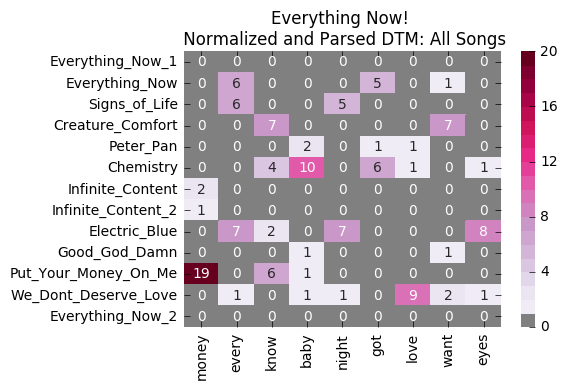

In [8]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

# define the colormap
cmap = plt.cm.PuRd

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)

# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# Define color bins and normalize
bounds = np.linspace(0,20,21)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Plot using a heat map of normalized dtm rates
sns.heatmap(top_words.ix[:, 0:9], annot=True, fmt="d", cmap=cmap, norm=norm)
plt.title("Everything Now! \n Normalized and Parsed DTM: All Songs")
plt.tight_layout()
plt.show()

### Normalization: Part Deux
Now that we saw what happens when we normalize word usage across all songs per 1000 words, let's now normalize word usage by song. This should give unique words that are repeated in lyrically short songs greater weight... the thinking goes that it would better emphasize the author's intent to convey a message.

Indeed, after running through the code again, we see the interlude and exitlude song score high across the top 10 words as those songs are short and contain many repeated unique words.

I'm sure the Arcade Fire would get a good laugh out of the top 3 words found through this technique. Make Everything Money.

In [9]:
# Normalize per 1000 words over each songs
rates = 1000 * dtm / np.sum(dtm, axis=1, keepdims=True)

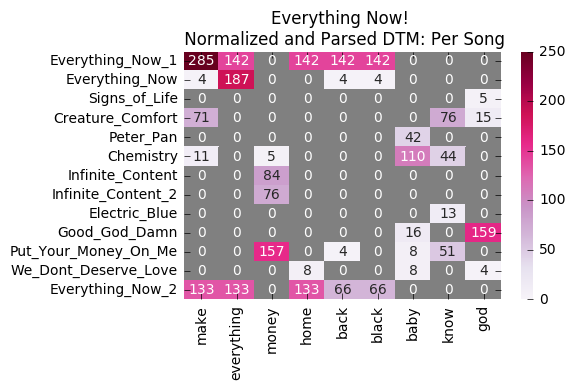

In [ ]:
# Average rates and sort by ranking
rates_avg = np.mean(rates, axis=0)
ranking = np.argsort(rates_avg)[::-1]

# Create data frame based on normalized dtm
top_words = pd.DataFrame(data=rates[:, ranking[:]],  # values based on average dtm rates
                         index=song_list,            # index on song name
                         columns=vocab[ranking[:]])  # columns of words

# Remove words that appear in 3 songs or less
uncommon = top_words[top_words == 0].count() > 10
uncommon = uncommon[uncommon == True]

uncommon = [str(uncommon.index[x]) for x in range(len(uncommon.index))]
unwanted_words = [column for column in top_words.columns if column in uncommon]

top_words = top_words.drop(labels=unwanted_words, axis=1)

# Begin plotting details

# define the colormap
cmap = plt.cm.PuRd

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)

# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# Define color bins and normalize
bounds = np.linspace(0,250,251)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Plot using a heat map of normalized dtm rates
sns.heatmap(top_words.ix[:, 0:9], annot=True, fmt="d", cmap=cmap, norm=norm)
plt.title("Everything Now! \n Normalized and Parsed DTM: Per Song")
plt.tight_layout()
plt.show()

May the irony of conducting quantiative analysis on this album not be lost.
<br>
<br>

"You could have never predicted that it could see through you <br>
Kasparov, Deep Blue, 1996 <br>
Your mind's playing tricks now <br>
Show's over so take a bow" <br>
<br>
-Deep Blue, Arcade Fire (2010)